In [14]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import cv2
import matplotlib.pyplot as plt


In [15]:
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml') # cascade classifier
model_svm = pickle.load(open('./model/model_svm.pickle', mode = 'rb'))  # machine learning model
pca_models = pickle.load(open('./model/pca_dict.pickle', mode = 'rb')) # pca dict

In [16]:
model_pca = pca_models['pca']
mean_face_arr = pca_models['mean_face']

male : 83
female : 93
male : 72


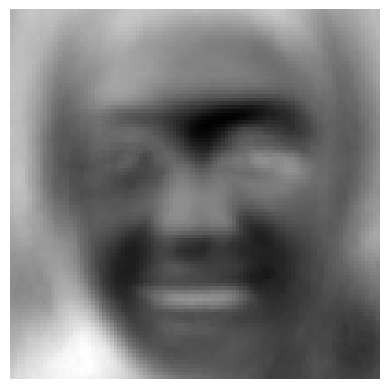

In [24]:
img = cv2.imread('./test_images/getty_test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = haar.detectMultiScale(gray, 1.3, 5)
predictions = []
for x,y,w,h in faces:
    # cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 3)
    roi= gray[y:y+h, x:x+w]

    roi = roi/255.0
    if roi.shape[1] > 100:
        roi_resize = cv2.resize(roi, (100,100), cv2.INTER_AREA)
    else:
        roi_resize = cv2.resize(roi, (100,100), cv2.INTER_CUBIC)
    roi_reshape = roi_resize.reshape(1,10000)
    roi_mean = roi_reshape - mean_face_arr
    #apply the pca
    eigen_image = model_pca.transform(roi_mean)
    eig_img  = model_pca.inverse_transform(eigen_image)
    
    
    #pass to the model
    results = model_svm.predict(eigen_image)
    prob_score = model_svm.predict_proba(eigen_image)
    prob_score_max = prob_score.max()
    text = '%s : %d'%(results[0], prob_score_max*100)
    print(text)
    
    if results[0] == 'male':
        color = (255,255,0)
    else:
        color = (255,0,255)
    
    cv2.rectangle(img, (x,y), (x+w, y+h), color, 3)
    cv2.rectangle(img,(x,y-40), (x+w, y), color, -1)
    cv2.putText(img,text, (x,y), cv2.FONT_HERSHEY_PLAIN,3,(255,255,255),5)
    
    output = {
        'roi': roi,
        'eig_img': eig_img,
        'prediction_name': results[0],
        'score': prob_score_max
        }
    predictions.append(output)

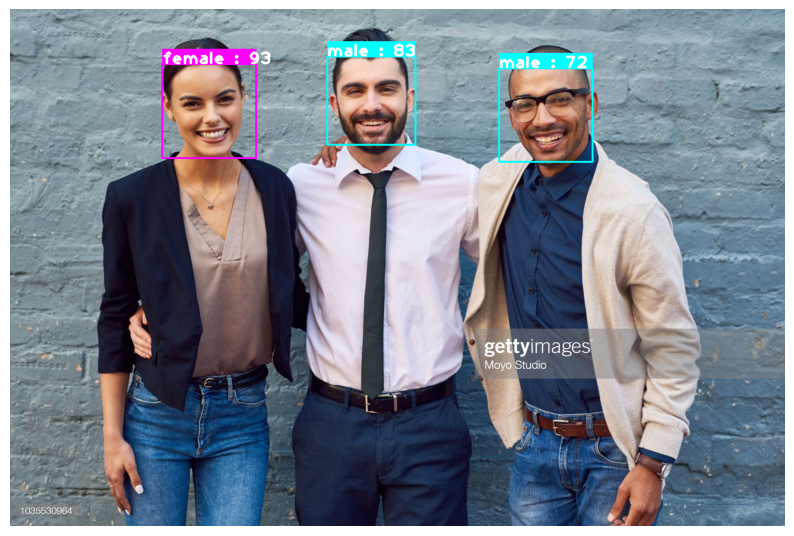

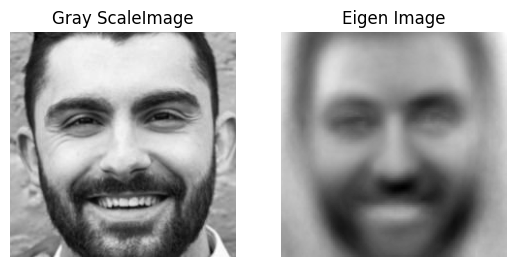

Predicted Gender =  male
predicted Score = 83.59 %
----------------------------------------------------------------------------------------------------


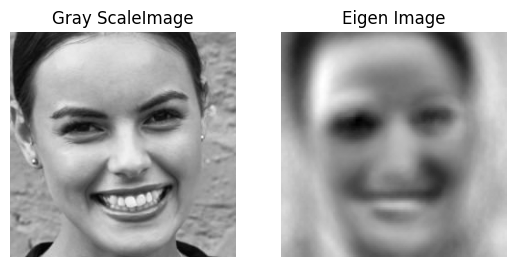

Predicted Gender =  female
predicted Score = 93.98 %
----------------------------------------------------------------------------------------------------


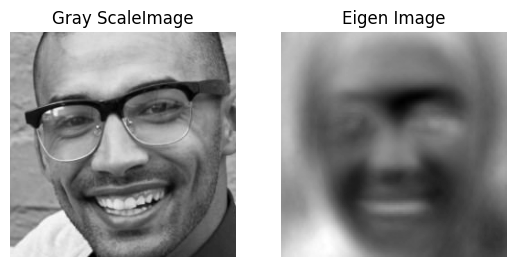

Predicted Gender =  male
predicted Score = 72.04 %
----------------------------------------------------------------------------------------------------


In [26]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

## generate the report
for i in range(len(predictions)):
    obj_gray = predictions[i]['roi']# gray scale
    obj_eig = predictions[i]['eig_img'].reshape((100,100)) # eigen image
    plt.subplot(1,2,1)
    plt.imshow(obj_gray, cmap='gray')
    plt.title('Gray ScaleImage')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(obj_eig, cmap='gray')
    plt.title('Eigen Image')
    plt.axis('off')
    plt.show()
    
    print('Predicted Gender = ', predictions[i]['prediction_name'])
    print('predicted Score = {:,.2f} %'.format(predictions[i]['score']*100))
    print('-'*100)